# Example of getting nan in the first frequency.

This is an error that appears occasionally near the start of the sampling where a particular draw from the prior produces a nan value in the set of mixed mode frequencies. Dynesty can't handle nan so the sampling can't be initialized.

From what I can tell this problem occurs when prior draw produces a numax which is dramatically different from the target numax, in combination with when the asymptotic g-mode parameters are supplied manually. The asymptotic g-mode parameters are then vastly different from what shoudl be expected for that particular numax draw.

For some reason, when it comes to solving the eigen value problem of L and D to get the mixed mode frequencies, one of the eigenvalues Lambda becomes positive where they should be negative. Since the mode frequencies are given by $\omega = (-\Lambda)^2$, this results in that frequency being nan. 

We should in principle be able to ignore this issue in the future, since the prior will know what DPi0 goes with what numax, but it would be nice to know why we get positive $\Lambda$ values from the L and D matrices. 

In [13]:
%load_ext autoreload
%autoreload 2
from pbjam.modeID import modeIDsampler
from pbjam import IO
import corner
import jax.numpy as jnp
import pbjam.distributions as dist
import numpy as np
from scipy.linalg import eigh as seigh
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load in some dummy data so we can initialize the class

In [2]:
psd = IO.psd('KIC7976303', lk_kwargs={'exptime': 60, 'mission':'Kepler', 'author':'Kepler'})

psd()

f = psd.freq[::10]

s = psd.powerdensity[::10]

Using cached search result.
Loading fits files from cache.


## Priors and Observations
The addObs dictionary is used to select the relevant target range of the prior.

The addPriors dictionary is used to specify independent priors for each of the listed parameters. These are *not* included in the dimensionality reduction.

In [3]:
addObs = {'numax' : (900.17, 80),
          'dnu'  : (51.24, 0.21),
          'teff': (6053, 10.0),
          'bp_rp': (0.719, 0.05), 
          } 

addPriors = {'p_L0': dist.beta(a=1.2, b=1.2, loc=0.04, scale=0.06),
             'p_D0': dist.beta(a=1.2, b=1.2, loc=-0.04, scale=0.04),
             'DPi0': dist.normal(loc=0.000519, scale=0.000519*0.01),
             'eps_g': dist.normal(loc=0.81, scale=0.01),
             'd01': dist.normal(loc=np.log10(24), scale=0.01),
             'alpha_g': dist.normal(loc=np.log10(0.02), scale=0.5),
            }

## Initialize the sampling class
This is effectively asy_peakbag from the old version of PBjam.

In [4]:
N_p = 15 # p-mode orders

N_pca = 200 # Number of samples to used for PCA

PCAdims = 8 # Number dimensions for the latent space.
 
M = modeIDsampler(f, s, addObs, addPriors, N_p=N_p, Npca=N_pca, PCAdims=PCAdims, priorpath=IO.get_priorpath(), freq_limits = [100, 2000])

## Sample that produces nan

This is just an example of a sample drawn from the prior above which produces a nan frequency.

Note that numax is very small, corresponding to a red giant perhaps. In contrast, the prior we have specified above assumes we're looking at a subgiant star. 

I think this is where the issue comes from.

In [5]:
v=jnp.array([ 1.26105197e+01, -2.09269972e+00, -1.58912585e+00, -7.15306882e-01,
             -1.01949253e+00, -2.16685269e-01,  6.60950953e-01,  1.09379960e+00,
              7.02136291e-02, -1.32866941e-02,  5.15077069e-04,  8.15679489e-01,
             -5.77050777e-01,  1.35431965e+00, -1.88545218e+00,  7.53681830e-01,
              2.23390255e+00, -2.78242778e-01,  2.05914413e+00,  4.56415754e-02])

r = M.unpackParams(v)

print(r)

{'DPi0': Array(0.00051508, dtype=float64), 'H1_exp': Array(3.37108243, dtype=float64), 'H1_nu': Array(56.55857212, dtype=float64), 'H2_exp': Array(1.27358296, dtype=float64), 'H2_nu': Array(17.1528616, dtype=float64), 'H3_exp': Array(2.05914413, dtype=float64), 'H3_nu': Array(0.52693521, dtype=float64), 'H3_power': Array(171.35727611, dtype=float64), 'H_power': Array(24824.75301112, dtype=float64), 'alpha_g': Array(0.26481905, dtype=float64), 'alpha_p': Array(0.00554461, dtype=float64), 'bp_rp': Array(1.06588965, dtype=float64), 'd01': Array(22.61099375, dtype=float64), 'd02': Array(0.90883407, dtype=float64), 'dnu': Array(5.85279322, dtype=float64), 'env_height': Array(27.91843632, dtype=float64), 'env_width': Array(4.37121207, dtype=float64), 'eps_g': Array(0.81567949, dtype=float64), 'eps_p': Array(1.30814367, dtype=float64), 'inc': Array(0.75368183, dtype=float64), 'mode_width': Array(0.06208078, dtype=float64), 'numax': Array(59.72979185, dtype=float64), 'nurot_c': Array(0.0130181

In [9]:
nu0_p, n_p = M.AsyFreqModel.asymptotic_nu_p(r['numax'], r['dnu'], r['eps_p'], r['alpha_p'])
nu1_p = nu0_p + r['d01']  

print(nu0_p)

[14.52101847 20.13376169 25.77895637 31.45660249 37.16670005 42.90924907
 48.68424954 54.49170145 60.33160481 66.20395961 72.10876587 78.04602357
 84.01573272 90.01789332 96.05250536]


In [10]:
nu_g = M.MixFreqModel.asymptotic_nu_g(M.MixFreqModel.n_g, r['DPi0'], r['eps_g'], r['alpha_g'])

print(nu_g)

[350.16000089 486.71417182 691.44220488 970.10819746]


In [17]:
L, D = M.MixFreqModel.generate_matrices(n_p, M.MixFreqModel.n_g, nu1_p, nu_g, r['p_L'], r['p_D'])
L, D = np.array(L), np.array(D)

## Does this look like what we expect?

I could have sworn the g-modes should be at the top. Does it ma

Text(0, 2.5, 'D')

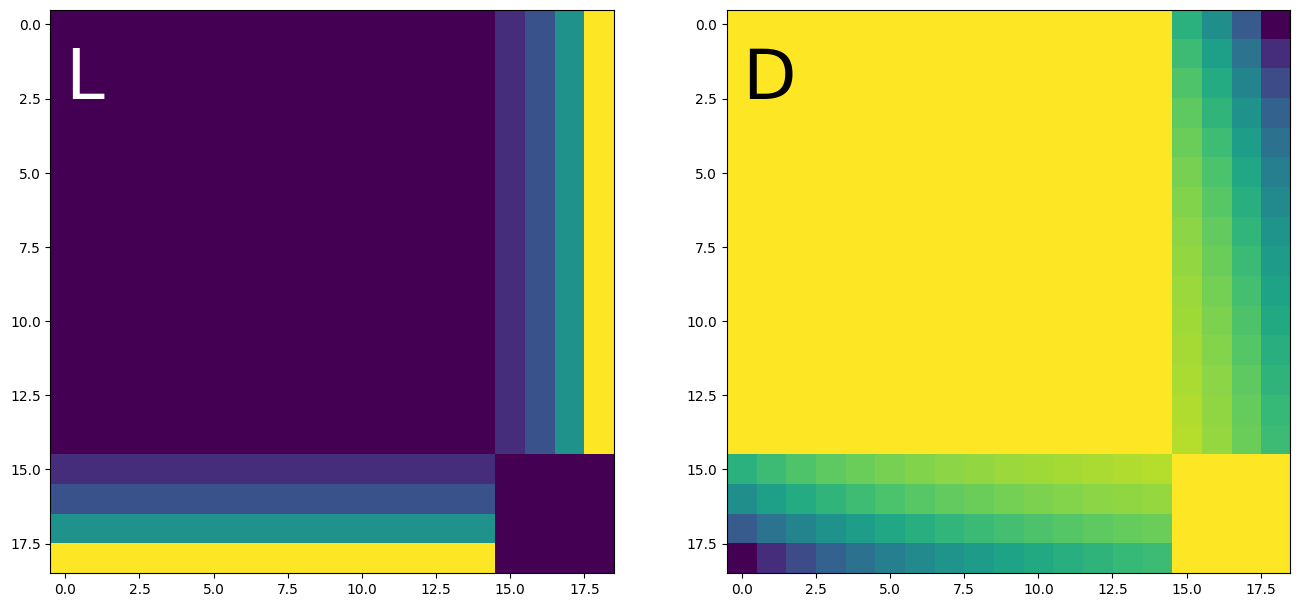

In [27]:
fig, ax = plt.subplots(1,2, figsize=(16,9))

for i in range(L.shape[0]):
    L[i,i] = 0
    D[i,i] = 0

ax[0].imshow(L)
ax[0].text(0, 2.5, s='L', fontsize=50, color='w')
ax[1].imshow(D)
ax[1].text(0, 2.5, s='D', fontsize=50, color='k')